# Projekt: Prediction on Prediction(-s) -> Sun_Spot

In [1]:
import numpy as np
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
%matplotlib inline
from numpy import array
import datetime
import webbrowser
from IPython.display import clear_output, Image, display, HTML
import math
import io
import shutil
import glob
import os
from tensorflow.python.ops import array_ops

model_name = "sun_spot" #important for directory_name and tensorboard
logs_path='logs_' + model_name + '/'

In [2]:
def delete_logs_archive():
    try:
        shutil.rmtree(logs_path)
    except OSError:
        pass

In [3]:
delete_logs_archive()

In [4]:
# expect something like this (e.g.): plot_dataframe_with_args([source_data_x,source_data_y,color],[result_data_x, result_data_y, color]) 
def plot_dataframe_with_args(*args):#(x_source, y_source, color_source, x_results, y_results, color_results, add_offset = False):
    print("\nNumber of existing points: ", len(args[0][1]))
    for i in args:
        if i != args[0]:
            print("Number of predicted points: ", len(i[1]))
    print("\n")
    plt.figure(figsize=(60, 15))
    plt.title('stock market prediction - Prediction on Prediction')
    plt.xlabel('days')
    plt.ylabel('dayli-closing-price in Dollar')
    for i in args:
        plt.plot(i[0],i[1],i[2]) 
    plt.show()

In [5]:
#expected soemthing like this (e.g.): load_plot_to_tensorboard([range(len(train_data)),train_data,'k',"simple presentation of orginal data"], [same structue], ..., z)
#expected something like this (e.g.): load_plot_to_tensorboard_x_plots_y_scatter()
def load_plot_to_tensorboard_x_plots_y_scatter(plots=[],scatter=[],name="Not Specified"):
    plt.ioff()
    plt.figure(figsize=(40, 15))
    plt.title('stock market prediction - Prediction on Prediction')
    for i in plots:
        plt.plot(i[0],i[1],i[2])
    for j in scatter:
        plt.scatter(x=j[0],y=j[1],c=j[2]) 
    buf = io.BytesIO()
    plt.savefig(buf, format='png')
    plt.close()
    buf.seek(0)
    image=tf.image.decode_png(buf.getvalue(), channels=4)
    image = tf.expand_dims(image, 0)
    return tf.summary.image(name,image,max_outputs=1)

In [6]:
# data_list expected: [data_set,scaled_dataset,training_data,test_data]
def create_and_add_summaries(data_list,writer=None,session=None):
    color_original_data_plot='b'
    color_train_data_plot='g'
    color_original_data_scatter='blue'
    color_train_data_scatter='green'
    color_test_data_plot='m'
    color_test_data_scatter="magenta"
    
    summary_original_unscaled = session.run(load_plot_to_tensorboard_x_plots_y_scatter([[range(len(data_list[0])),data_list[0],color_original_data_plot]],name="UNSCALED_ORIGINAL_DATA_PLOT"))
    summary_original = session.run(load_plot_to_tensorboard_x_plots_y_scatter([[range(len(data_list[1])),data_list[1],color_original_data_plot]],name="ORIGINAL_DATA_PLOT"))
    summary_train = session.run(load_plot_to_tensorboard_x_plots_y_scatter([[range(window_size,window_size+len(data_list[2])),data_list[2],color_train_data_plot]],name="TRAIN_DATA_PLOT"))
    summary_original_with_train = session.run(load_plot_to_tensorboard_x_plots_y_scatter([[range(len(data_list[1])),data_list[1],color_original_data_plot],[range(window_size,window_size+len(data_list[2])),data_list[2],color_train_data_plot]],name="ORIGINAL_DATA_AND_TRAIN_DATA_PLOT"))
    summary_test = session.run(load_plot_to_tensorboard_x_plots_y_scatter([[range(window_size+train_range ,window_size+ train_range+ len(data_list[3])),data_list[3],color_test_data_plot]],name="TEST_DATA_PLOT"))
    summary_test_with_train = session.run(load_plot_to_tensorboard_x_plots_y_scatter([[range(window_size+train_range ,window_size+ train_range+ len(data_list[3])),data_list[3],color_test_data_plot],[range(window_size,window_size+len(data_list[2])),data_list[2],color_train_data_plot]],name="TEST_AND_TRAIN_DATA_PLOT"))
    summary_all = session.run(load_plot_to_tensorboard_x_plots_y_scatter([[range(len(data_list[1])),data_list[1],color_original_data_plot],[range(window_size,window_size+len(data_list[2])),data_list[2],color_train_data_plot],[range(window_size+train_range ,window_size+ train_range+ len(data_list[3])),data_list[3],color_test_data_plot]],name="SUMMARIZE_ALL_PLOT"))
    
    summary_original_scatter = session.run(load_plot_to_tensorboard_x_plots_y_scatter([],[[range(len(data_list[1])),data_list[1],color_original_data_scatter]],name="ORIGINAL_DATA_SCATTER"))
    summary_train_scatter = session.run(load_plot_to_tensorboard_x_plots_y_scatter([],[[range(window_size,window_size+len(data_list[2])),data_list[2],color_train_data_scatter]],name="TRAIN_DATA_SCATTER"))
    summary_original_with_train_scatter = session.run(load_plot_to_tensorboard_x_plots_y_scatter([],[[range(len(data_list[1])),data_list[1],color_original_data_scatter],[range(window_size,window_size+len(data_list[2])),data_list[2],color_train_data_scatter]],name="ORIGINAL_DATA_AND_TRAIN_DATA_SCATTER"))
    summary_test_scatter = session.run(load_plot_to_tensorboard_x_plots_y_scatter([],[[range(window_size+train_range ,window_size+ train_range+ len(data_list[3])),data_list[3],color_test_data_scatter]],name="TEST_DATA_SCATTER"))
    summary_test_with_train_scatter = session.run(load_plot_to_tensorboard_x_plots_y_scatter([],[[range(window_size+train_range ,window_size+ train_range+ len(data_list[3])),data_list[3],color_test_data_scatter],[range(window_size,window_size+len(data_list[2])),data_list[2],color_train_data_scatter]],name="TEST_AND_TRAIN_DATA_SCATTER"))
    summary_all_scatter = session.run(load_plot_to_tensorboard_x_plots_y_scatter([],[[range(len(data_list[1])),data_list[1],color_original_data_scatter],[range(window_size,window_size+len(data_list[2])),data_list[2],color_train_data_scatter],[range(window_size+train_range ,window_size+ train_range+ len(data_list[3])),data_list[3],color_test_data_scatter]],name="SUMMARIZE_ALL_SCATTER"))
    
    summary_list = [summary_original_unscaled,summary_original,summary_train,summary_original_with_train,summary_test,summary_test_with_train,summary_all,summary_original_scatter,summary_train_scatter,summary_original_with_train_scatter,summary_test_scatter,summary_test_with_train_scatter,summary_all_scatter]
    for i in summary_list:
        writer.add_summary(i)
    

In [7]:
def run_tensorboard_in_browser(cleanup=False):
    webbrowser.open('http://Flo:6006') #eig 'http://localhost:6006'
    !tensorboard --logdir=logs_path
    if cleanup:
        delete_logs_archive()

In [8]:
def strip_consts(graph_def, max_const_size=32):
    """Strip large constant values from graph_def."""
    strip_def = tf.GraphDef()
    for n0 in graph_def.node:
        n = strip_def.node.add() 
        n.MergeFrom(n0)
        if n.op == 'Const':
            tensor = n.attr['value'].tensor
            size = len(tensor.tensor_content)
            if size > max_const_size:
                tensor.tensor_content = "<stripped %d bytes>"%size
    return strip_def

def run_tensorboard_in_jupiter(graph_def, max_const_size=32):
    if hasattr(graph_def, 'as_graph_def'):
        graph_def = graph_def.as_graph_def()
    strip_def = strip_consts(graph_def, max_const_size=max_const_size)
    code = """
        <script>
          function load() {{
            document.getElementById("{id}").pbtxt = {data};
          }}
        </script>
        <link rel="import" href="https://tensorboard.appspot.com/tf-graph-basic.build.html" onload=load()>
        <div style="height:600px;">
          <tf-graph-basic id="{id}"></tf-graph-basic>
        </div>
    """.format(data=repr(str(strip_def)), id='graph'+str(np.random.rand()))
    iframe = """
        <iframe seamless style="width:1500px;height:700px;border:0" srcdoc="{}"></iframe>
    """.format(code.replace('"', '&quot;'))
    display(HTML(iframe))

In [9]:
def write_global_parameters_to_tensorboard(sess,writer):
    parameters = model_name + "   ||   window_size=" + str(window_size) + "   ||   batch_size=" + str(batch_size) + "   ||   epochs=" + str(epochs) + "   ||   train_range=" + str(train_range) + "   ||   dropout_rate=" + str(dropout_rate) + "   ||   number_of_lstm_layers=" +  str(number_of_lstm_layers) + \
                    "   ||   learning_rate=" + str(learning_rate) + "   ||   neurons_at_gate=" + str(neurons_at_gate) + "   ||   number_of_classes" + str(number_of_classes) + "   ||   decimal_place=" + str(decimal_place) + "   ||   clip_on" + str(clip_on) + \
                    "   ||   number_of_disired_batches_predictions=" + str(number_of_disired_batches_predictions) + "   ||   feature_size=" + str(feature_size)
    summary_op3 = tf.summary.text('parameters', tf.convert_to_tensor(parameters))
    text = sess.run(summary_op3)
    writer.add_summary(text)

In [10]:
def read_dataframe_and_output_dataset(name):
    tesla_stocks = pd.read_csv(name, sep=';')
    tesla_stocks.head()
    data_to_use = tesla_stocks['SSN'].values
    data_to_use = np.flipud(data_to_use) # flips values to get the newest values to the end
    return data_to_use
    

In [11]:
def scale_dataset(min,max,dataset): #dataset shape: [x]
    scaler = MinMaxScaler(feature_range=(min,max))
    scaler = scaler.fit(dataset)
    scaled_dataset = scaler.transform(dataset)
    return scaler, scaled_dataset

In [12]:
def scale_dataset_back(scaler, dataset): #dataset shape: [x]
    return scaler.inverse_transform(dataset)

In [13]:
#if reshaped = False ->(None) to (None,1)
#if reshaped = True -> (None,1) to (None)
def reshape_dataset(dataset, reshaped):
    if reshaped is False:
        dataset = np.reshape(dataset, (-1,1))
    else:
        dataset = np.reshape(dataset, (-1))
    return dataset    

In [14]:
#requires dataset of shape (-1,1)
def window_data(reshaped_data, window_size):
    x = []
    y = []    
    i = 0
    while (i + window_size) <= len(reshaped_data) - 1:
        x.append(reshaped_data[i:i+window_size])
        y.append(reshaped_data[i+window_size])        
        i += 1
    assert len(x) ==  len(y)
    return x, y

In [15]:
#requires windowed_dataset
def create_trains(windowed_data_x,windowed_data_y):
    x_train  = np.array(windowed_data_x[:train_range])
    y_train = np.array(windowed_data_y[:train_range])

    x_test = np.array(windowed_data_x[train_range:])
    y_test = np.array(windowed_data_y[train_range:])
    return x_train, y_train, x_test, y_test

In [16]:
def create_lstm_cell_with_MultiRNN_Dropout(neurons_at_gate, batch_size,number_of_lstm_layers,dropout_rate):
    with tf.name_scope("create_LSTM_hiddenlayer"):
        layer_list = []
        for counter in range(number_of_lstm_layers):
            layer = tf.nn.rnn_cell.BasicLSTMCell(neurons_at_gate)
            if dropout_rate != 0:
                layer = tf.contrib.rnn.DropoutWrapper(layer, output_keep_prob=dropout_rate)
            layer_list.append(layer)     
        cell = tf.contrib.rnn.MultiRNNCell(layer_list)  
        init_state = cell.zero_state(1, tf.float32) 
        return cell, init_state

In [17]:
# use for given accuracy function
#requires x shape of: 
def my_tf_round(x, decimal_place = 0):
    with tf.name_scope("round_numbers"):
        multiplier = tf.constant(10**decimal_place, dtype=x.dtype, name="multiplier_for_accuracy")
        return tf.round(x * multiplier) / multiplier

In [18]:
# requires logits and labels shape of: (batch_size,feature_size), normal_case: (8,1)
def accuracy(logits,labels,decimal_place):
    with tf.name_scope("compute_accuracy"):
        targets_rounded = my_tf_round(labels,decimal_place)
        logits_rounded = my_tf_round(logits,decimal_place)
        correct_prediction=tf.equal(logits_rounded,targets_rounded)
        accuracy_result=tf.reduce_mean(tf.cast(correct_prediction,tf.float32),name="Create_Mean")
        summary_acc2 = tf.summary.scalar("acc",accuracy_result)
#         merged_summary_op_acc = tf.summary.merge_all()
        return accuracy_result, summary_acc2

In [19]:
def input_layer():
    with tf.name_scope("input_layer"):
        x_batch = tf.placeholder(tf.float32, [1, window_size, 1], name='x_batch')
        y_batch = tf.placeholder(tf.float32, [batch_size, 1], name='y_batch')
        return x_batch,y_batch

In [20]:
# def compute_rnn(x_batch,cell1,initial_state):
#     output_dynamic_cell,states = tf.nn.dynamic_rnn(cell1, x_batch, initial_state=initial_state)
#     return output_dynamic_cell, states

In [21]:
def output_layer_create_variables(neurons_at_gate,number_of_features):
    with tf.name_scope("create_output_weights_and_biases"):
        weights = tf.Variable(tf.truncated_normal([neurons_at_gate, number_of_features], stddev=0.05), name='output_layer_weights')
        bias = tf.Variable(tf.zeros([number_of_features]), name='output_layer_bias')
        return weights, bias

In [22]:
#lstm_output = (batch_size,window_size,neurons_at_gate)
#number of classes = often 1
#predictions_for_batch = (batch_size,number_of_features)
def output_layer_calculation(lstm_output, neurons_at_gate, number_of_features,weights,bias):
    with tf.name_scope("output_layer"):
        x = lstm_output[:, -1, :] 
        predictions_for_batch = tf.matmul(x, weights) + bias 
        return predictions_for_batch

In [23]:
def condition(index_condition, up_to_condition,inputs_condition,hidden_layer_size_condition, number_of_classes_condition,logits_list_condition,initial_state_condition,weights_condition, bias_condition,summeries_in_while_condition):
    with tf.name_scope("model_loop_condition"):
        return tf.less(index_condition,up_to_condition)

def loop_dynamic_cell_body(index_body, up_to_body,inputs_body,hidden_layer_size_body, number_of_classes_body,logits_list_body,initial_state_body,weights_body, bias_body,summeries_in_while_body):
    with tf.name_scope("record_output_summaries"):
        summeries_in_while_body = tf.concat([summeries_in_while_body,[tf.summary.histogram("output_layer_weights", weights_body)]],0,name="summarie_output_weights")
        summeries_in_while_body = tf.concat([summeries_in_while_body,[tf.summary.histogram("output_layer_bias", bias_body)]],0,name="summarie_output_bias")
#     with tf.name_scope("record_body_index"):
#         summeries_in_while_body = tf.concat([summeries_in_while_body,[tf.summary.scalar("index_body",index_body)]],0,name="summarie_index")
    with tf.name_scope("model_loop_body"):
        with tf.name_scope("unpack_init_state_to_tupel"):
            in_tupel_body = tuple([tf.nn.rnn_cell.LSTMStateTuple(initial_state_body[idx][0],initial_state_body[idx][1]) for idx in range(number_of_lstm_layers)])
        with tf.name_scope("dynamic_cell_run"):
            outputs_partial, initial_state_output_dynamic = tf.nn.dynamic_rnn(cell,inputs_body,initial_state=in_tupel_body) 
        with tf.name_scope("logit_into_output_layer"):
            logit = output_layer_calculation(outputs_partial, hidden_layer_size_body, number_of_classes_body,weights_body, bias_body) #logit: 1x1
        with tf.name_scope("add_logit_to_input"):
            logits_list_body = tf.concat([logits_list_body,logit],0,name="add_logit_to_logitlist")
            inputs_body = tf.reshape(inputs_body, [-1],name="reshape_inputs_to_-1") #reshape to get a simple 1 dim list
            inputs_body = inputs_body[1:] # get rid of first value
            logit = tf.reshape(logit,[-1],name="reshape_logit_to_-1") #reshape to get a simple 1 dim list with 1 value  
            inputs_body= tf.concat([inputs_body,logit],0,name="add_logit_to_input") #append logit to the end of inputs    
            inputs_body = tf.reshape(inputs_body, [-1,window_size,1],name="reshape_input_back") # transform back
            in_list_body_out = tf.convert_to_tensor(list(initial_state_output_dynamic),name="pack_init_state_to_tensor")
        summeries_in_while_body = tf.concat([summeries_in_while_body,[tf.summary.histogram("init_state_during_while", initial_state_body)]],0,name="record_init_state_during_while")
        for variables in cell.variables:
            summeries_in_while_body = tf.concat([summeries_in_while_body,[tf.summary.histogram(variables.name + "_DURING_WHILE", variables)]],0,name="summarie_cell_variables")
        with tf.name_scope("increase_index_body_para_by_1"):
            index_body=index_body+1
        return index_body, up_to_body,inputs_body,hidden_layer_size_body, number_of_classes_body,logits_list_body,in_list_body_out,weights_body, bias_body,summeries_in_while_body #im Moment können wir last_state noch weglassen, da wir mit ihm ehh nichts machen

In [24]:
#outputs predictions with shape: [batch_size,1]
def combining_rnn_and_output(inputs,hidden_layer_size, number_of_classes,initial_state,weights, bias):
    with tf.name_scope("full_model"):
        with tf.name_scope("create_summary_buffer"):
            summeries_not_in_while = tf.Variable([],dtype=tf.string,trainable=False,name="summarie_buffer_not_in_while")
            summeries_in_while = tf.Variable([],dtype=tf.string,trainable=False,name="summaries_buffer_in_while")
        with tf.name_scope("preparation_for_while"):
            index = tf.constant(0,name="index")
            up_to = tf.constant(batch_size,name="end_condition")
            logits_list = tf.get_variable("logit_list",shape=[0,1],trainable=False)
            in_list = tf.convert_to_tensor(list(initial_state),name="pack_init_state_to_tensor")
            tensor_hidden_layer_size = tf.constant(neurons_at_gate, name="para_neurons_at_gate_in_tensor")
            tensor_number_of_classes = tf.constant(number_of_classes,name="para_number_of_classes_in_tensor")
        with tf.name_scope("while_call"):
            index_definition, up_to_definition,inputs_definition,hidden_layer_size_definition, number_of_classes_definition,logits_definition,initial_state_definition, weights_definition,bias_definition,summeries_in_while_definition = tf.while_loop(condition,loop_dynamic_cell_body,loop_vars=[index,up_to,inputs,tensor_hidden_layer_size, tensor_number_of_classes,logits_list,in_list,weights, bias,summeries_in_while],shape_invariants=[index.get_shape(),up_to.get_shape(),inputs.get_shape(), tensor_hidden_layer_size.get_shape(), tensor_number_of_classes.get_shape(),tf.TensorShape([None, 1]),in_list.get_shape(),weights.get_shape(), bias.get_shape(),tf.TensorShape([None])], back_prop=True,name="while_loop_model")
        with tf.name_scope("unpack_init_state_to_tupel"):
            in_tupel_definition = tuple([tf.nn.rnn_cell.LSTMStateTuple(initial_state_definition[idx][0],initial_state_definition[idx][1]) for idx in range(number_of_lstm_layers)]) # wird nicht verwendet
        with tf.name_scope("record_kernel_summaries"):
            for variables in cell.variables:
                summeries_not_in_while = tf.concat([summeries_not_in_while,[tf.summary.histogram(variables.name + "_AFTER_WHILE", variables)]],0)
                if "/kernel" in variables.name:
                    one = tf.constant(1, dtype=tf.int32)
                    w_i, w_C, w_f, w_o = array_ops.split(value=variables, num_or_size_splits=4, axis=one)
                    summeries_not_in_while = tf.concat([summeries_not_in_while,[tf.summary.histogram(variables.name + "_AFTER_WHILE_FORGETWEIGHTS", w_f)]],0,name="summarie_FORGETWEIGHTS")
                    summeries_not_in_while = tf.concat([summeries_not_in_while,[tf.summary.histogram(variables.name + "_AFTER_WHILE_UPDATEINPUTWEIGHTS", w_i)]],0,name="summarie_UPDATEINPUTWEIGHTS")
                    summeries_not_in_while = tf.concat([summeries_not_in_while,[tf.summary.histogram(variables.name + "_AFTER_WHILE_NEWINPUTWEIGHTS", w_C)]],0,name="summarie_NEWINPUTWEIGHTS")
                    summeries_not_in_while = tf.concat([summeries_not_in_while,[tf.summary.histogram(variables.name + "_AFTER_WHILE_OUTPUTWEIGHTS", w_o)]],0,name="summarie_OUTPUTWEIGHTS")
                if "/bias" in variables.name:
                    zero = tf.constant(0, dtype=tf.int32)
                    b_i,b_C,b_f, b_o = array_ops.split(value=variables, num_or_size_splits=4, axis=zero)
                    summeries_not_in_while = tf.concat([summeries_not_in_while,[tf.summary.histogram(variables.name + "_AFTER_WHILE_FORGETBIAS", b_f)]],0,name="summarie_FORGETBIAS")
                    summeries_not_in_while = tf.concat([summeries_not_in_while,[tf.summary.histogram(variables.name + "_AFTER_WHILE_UPDATEINPUTBIAS", b_i)]],0,name="summarie_UPDATEINPUTBIAS")
                    summeries_not_in_while = tf.concat([summeries_not_in_while,[tf.summary.histogram(variables.name + "_AFTER_WHILE_NEWINPUTBIAS", b_C)]],0,name="summarie_NEWINPUTBIAS")
                    summeries_not_in_while = tf.concat([summeries_not_in_while,[tf.summary.histogram(variables.name + "_AFTER_WHILE_OUTPUTBIAS", b_o)]],0,name="summarie_OUTPUTBIAS")
        with tf.name_scope("record_initstate_after_while"):
            summeries_not_in_while = tf.concat([summeries_not_in_while,[tf.summary.histogram("init_state_after_while", initial_state_definition)]],0)
        with tf.name_scope("merge_summarie_in_out_while"):
            merge = tf.concat([summeries_not_in_while,summeries_in_while_definition],0)#tf.summary.merge(summeries_in_while_definition)
        return logits_definition,merge

In [25]:
def loss(logits, targets):
    with tf.name_scope("loss-MSE"):
        losses = []
        for i in range(targets.get_shape()[0]):
            losses.append([(tf.pow(logits[i] - targets[i], 2))]) #mse      
        loss = tf.reduce_sum(losses)/(2*batch_size)
        summary_loss = tf.summary.scalar("loss",loss)
        return loss,summary_loss

In [26]:
def optimize(loss,learning_rate,clip_on):
    with tf.name_scope("optimizing"):
        with tf.name_scope("create_summary_buffer_gradients"):
            summeries_gradients = tf.Variable([],dtype=tf.string,trainable=False,name="summarie_buffer_gradients")
        gradients = tf.gradients(loss, tf.trainable_variables(),name="gradients_calculated")
        clipper_, _ = tf.clip_by_global_norm(gradients, clip_on,name="Clipper_is_set_to_4")
        optimizer = tf.train.AdamOptimizer(learning_rate,name="AdamOptimizer")
        
        grads = list(zip(gradients, tf.trainable_variables()))
        train_optimizer = optimizer.apply_gradients(grads,name="applyGradientsForOptimisation")
#         train_optimizer = optimizer.apply_gradients(zip(gradients, tf.trainable_variables()),name="applyGradientsForOptimisation")
        
        for grad, var in grads:
            summeries_gradients = tf.concat([summeries_gradients,[tf.summary.histogram(var.name + "/gradient", grad)]],0,name="summarie_gradient") 
        

        return train_optimizer,summeries_gradients

In [27]:
def run_batch_train(session,x_batch,y_batch):
    with tf.name_scope("TRAINING"):
        logits_train_result,merged_summary_result,loss_result,summary_loss_result,accuracy_result,summary_accuracy_result,optimizer_result,summary_gradients_result = session.run([logits,merged_summary_model,loss,summary_loss,accuracy_value,summary_accuracy,optimizer,summary_gradients],feed_dict={x_batch_placeholder:x_batch,y_batch_placeholder:y_batch})
        return logits_train_result,merged_summary_result,loss_result,summary_loss_result,accuracy_result,optimizer_result,summary_accuracy_result,summary_gradients_result

In [28]:
def run_batch_test(session,x_batch): #x_batch sollte eigentlich nur 1 window, mit dem man dann nicht nur 1 sondern x batches predicten kann
    with tf.name_scope("TESTING"):
        logits_test_result = session.run([logits],feed_dict={x_batch_placeholder:x_batch})
        return logits_test_result

In [29]:
def run_all_epoch(session,x_train,y_train,scaled_dataset,writer):
    total_batch=0
    for i in range(epochs):  
        ii = 0
        traind_scores = [] 
        epoch_loss = []
        accuracy = 0.0
        while(ii + batch_size) <= len(x_train): #ein Durchlauf = 1 batch = 1 BPTT = 1 Anpassung der Gewichte = 1x "Lernen"
            x_batch = x_train[ii] # 1 nur, da andere windows auto erstellt werden
            x_batch = np.reshape(x_batch,[1,window_size,1])
            y_batch = y_train[ii:ii+batch_size]
            logits,merged_summary_result,loss,summ_los,accuracy,optimizer,summary_accuracy_result1,summary_gradients_result1 = run_batch_train(session,x_batch,y_batch)
            total_batch+=1
            ii += batch_size  
            epoch_loss.append(loss)
            traind_scores.append(logits)
#             writer.add_summary(merged_summary_result, total_batch)
            writer.add_summary(summary_accuracy_result1,total_batch)
            
            #problem: since while_loop summaries have same total_batch_number, i guess tensorflow takes newest (last) summerie (with same name) and show its values 
            for summary_content in merged_summary_result:
                writer.add_summary(summary_content,total_batch)
            for summary_gradientss in summary_gradients_result1:
                writer.add_summary(summary_gradientss,total_batch)
            writer.add_summary(summ_los,total_batch)

        if (i % 1) == 0:
            print('\nEpoch {}/{}'.format((i+1), epochs), ' Current loss: {}'.format(np.mean(epoch_loss)))
    print("\n")
    trained_scores_reshaped_back = reshape_dataset(traind_scores, True)
    return trained_scores_reshaped_back

In [30]:
def test_network(session,x_test,writer):
    tests = []
    i = 0
    x_batch = x_test[0]# 1 nur, da andere windows auto erstellt werden
    x_batch = np.reshape(x_batch,[1,window_size,1])
    while i <= number_of_disired_batches_predictions:  
        logits = run_batch_test(session,x_batch)
        x_batch = logits
        i += 1
        tests.append(logits)
        
    tests_reshaped_back = reshape_dataset(tests, True)
    return tests_reshaped_back

In [31]:
def run_all(session):
    summary_writer = tf.summary.FileWriter(logs_path,session.graph)
    dataset=read_dataframe_and_output_dataset("SN_m_tot_V2.0.csv")
    reshaped_data = reshape_dataset(dataset, False)
    scaler, scaled_dataset = scale_dataset(-1,1,reshaped_data)
    windowed_data_x, windowed_data_y = window_data(scaled_dataset, window_size)
    x_train, y_train, x_test, y_test = create_trains(windowed_data_x,windowed_data_y)

    trained_values = run_all_epoch(session,x_train,y_train,scaled_dataset,summary_writer)
    plot_dataframe_with_args([range(len(scaled_dataset)),scaled_dataset, "w"],[range(window_size,len(trained_values)+ window_size), trained_values, "g"])
    testet_values = test_network(session,x_test,summary_writer)
    plot_dataframe_with_args([range(len(scaled_dataset)),scaled_dataset, "b"],[range(window_size,len(trained_values)+ window_size), trained_values, "g"],[range(train_range+ window_size,train_range + len(testet_values)+ window_size), testet_values, "k"])
    create_and_add_summaries([dataset,scaled_dataset,trained_values,testet_values],writer=summary_writer,session=session)
    write_global_parameters_to_tensorboard(session,summary_writer)
    summary_writer.close()

In [32]:
window_size = 40 #arbitrarily selectable value
batch_size = 40 #beides 30 war gut, mehr window/bach_size -> mehr epochs
# window_size have to be equal to batch_size at the moment

epochs = 40 #eig 3
train_range = 2500 #has to be dividable by batch_size
dropout_rate=0.0 #dropout zerstört prediction
number_of_lstm_layers= 1
learning_rate=0.001 #0,001 muss bei diesem Beispiel eigentlich so bleiben
neurons_at_gate=3
number_of_classes = 1 #ist glaube gleich mit number of features
decimal_place = 1
clip_on = 4
number_of_disired_batches_predictions = 20
feature_size = 1



#sin glaube
# window_size = 10 #arbitrarily selectable value
# batch_size = 10
# # window_size have to be equal to batch_size at the moment

# epochs = 40 #eig 3
# train_range = x #has to be dividable by batch_size
# dropout_rate=0.00
# number_of_lstm_layers= 1
# learning_rate=0.0001
# neurons_at_gate=100
# logs_path= 'logs/'
# number_of_classes = 1 #ist glaube gleich mit number of features
# decimal_place = 1
# clip_on = 4
# number_of_disired_batches_predictions = y

In [33]:
x_batch_placeholder,y_batch_placeholder = input_layer()
cell, initial_state = create_lstm_cell_with_MultiRNN_Dropout(neurons_at_gate, batch_size, number_of_lstm_layers,dropout_rate)    
weights_output_layer, bias_output_layer = output_layer_create_variables(neurons_at_gate,number_of_classes)
logits, merged_summary_model = combining_rnn_and_output(x_batch_placeholder,neurons_at_gate, number_of_classes,initial_state,weights_output_layer, bias_output_layer)
loss,summary_loss = loss(logits,y_batch_placeholder)
accuracy_value,summary_accuracy = accuracy(logits,y_batch_placeholder,decimal_place)
optimizer,summary_gradients= optimize(loss,learning_rate,clip_on)

INFO:tensorflow:Summary name rnn/multi_rnn_cell/cell_0/basic_lstm_cell/kernel:0_DURING_WHILE is illegal; using rnn/multi_rnn_cell/cell_0/basic_lstm_cell/kernel_0_DURING_WHILE instead.
INFO:tensorflow:Summary name rnn/multi_rnn_cell/cell_0/basic_lstm_cell/bias:0_DURING_WHILE is illegal; using rnn/multi_rnn_cell/cell_0/basic_lstm_cell/bias_0_DURING_WHILE instead.
INFO:tensorflow:Summary name rnn/multi_rnn_cell/cell_0/basic_lstm_cell/kernel:0_AFTER_WHILE is illegal; using rnn/multi_rnn_cell/cell_0/basic_lstm_cell/kernel_0_AFTER_WHILE instead.
INFO:tensorflow:Summary name rnn/multi_rnn_cell/cell_0/basic_lstm_cell/kernel:0_AFTER_WHILE_FORGETWEIGHTS is illegal; using rnn/multi_rnn_cell/cell_0/basic_lstm_cell/kernel_0_AFTER_WHILE_FORGETWEIGHTS instead.
INFO:tensorflow:Summary name rnn/multi_rnn_cell/cell_0/basic_lstm_cell/kernel:0_AFTER_WHILE_UPDATEINPUTWEIGHTS is illegal; using rnn/multi_rnn_cell/cell_0/basic_lstm_cell/kernel_0_AFTER_WHILE_UPDATEINPUTWEIGHTS instead.
INFO:tensorflow:Summary 

START

Epoch 1/40  Current loss: 0.21555818617343903

Epoch 2/40  Current loss: 0.160948246717453

Epoch 3/40  Current loss: 0.08079075813293457

Epoch 4/40  Current loss: 0.06063034012913704

Epoch 5/40  Current loss: 0.06012587994337082

Epoch 6/40  Current loss: 0.0600895918905735

Epoch 7/40  Current loss: 0.06001293659210205

Epoch 8/40  Current loss: 0.05994287133216858

Epoch 9/40  Current loss: 0.059885699301958084

Epoch 10/40  Current loss: 0.05983952805399895

Epoch 11/40  Current loss: 0.05980180576443672

Epoch 12/40  Current loss: 0.059770431369543076

Epoch 13/40  Current loss: 0.05974383279681206

Epoch 14/40  Current loss: 0.059720829129219055

Epoch 15/40  Current loss: 0.05970048904418945

Epoch 16/40  Current loss: 0.05968208611011505

Epoch 17/40  Current loss: 0.05966498702764511

Epoch 18/40  Current loss: 0.05964864790439606

Epoch 19/40  Current loss: 0.05963244289159775

Epoch 20/40  Current loss: 0.05961570516228676

Epoch 21/40  Current loss: 0.0595974810421

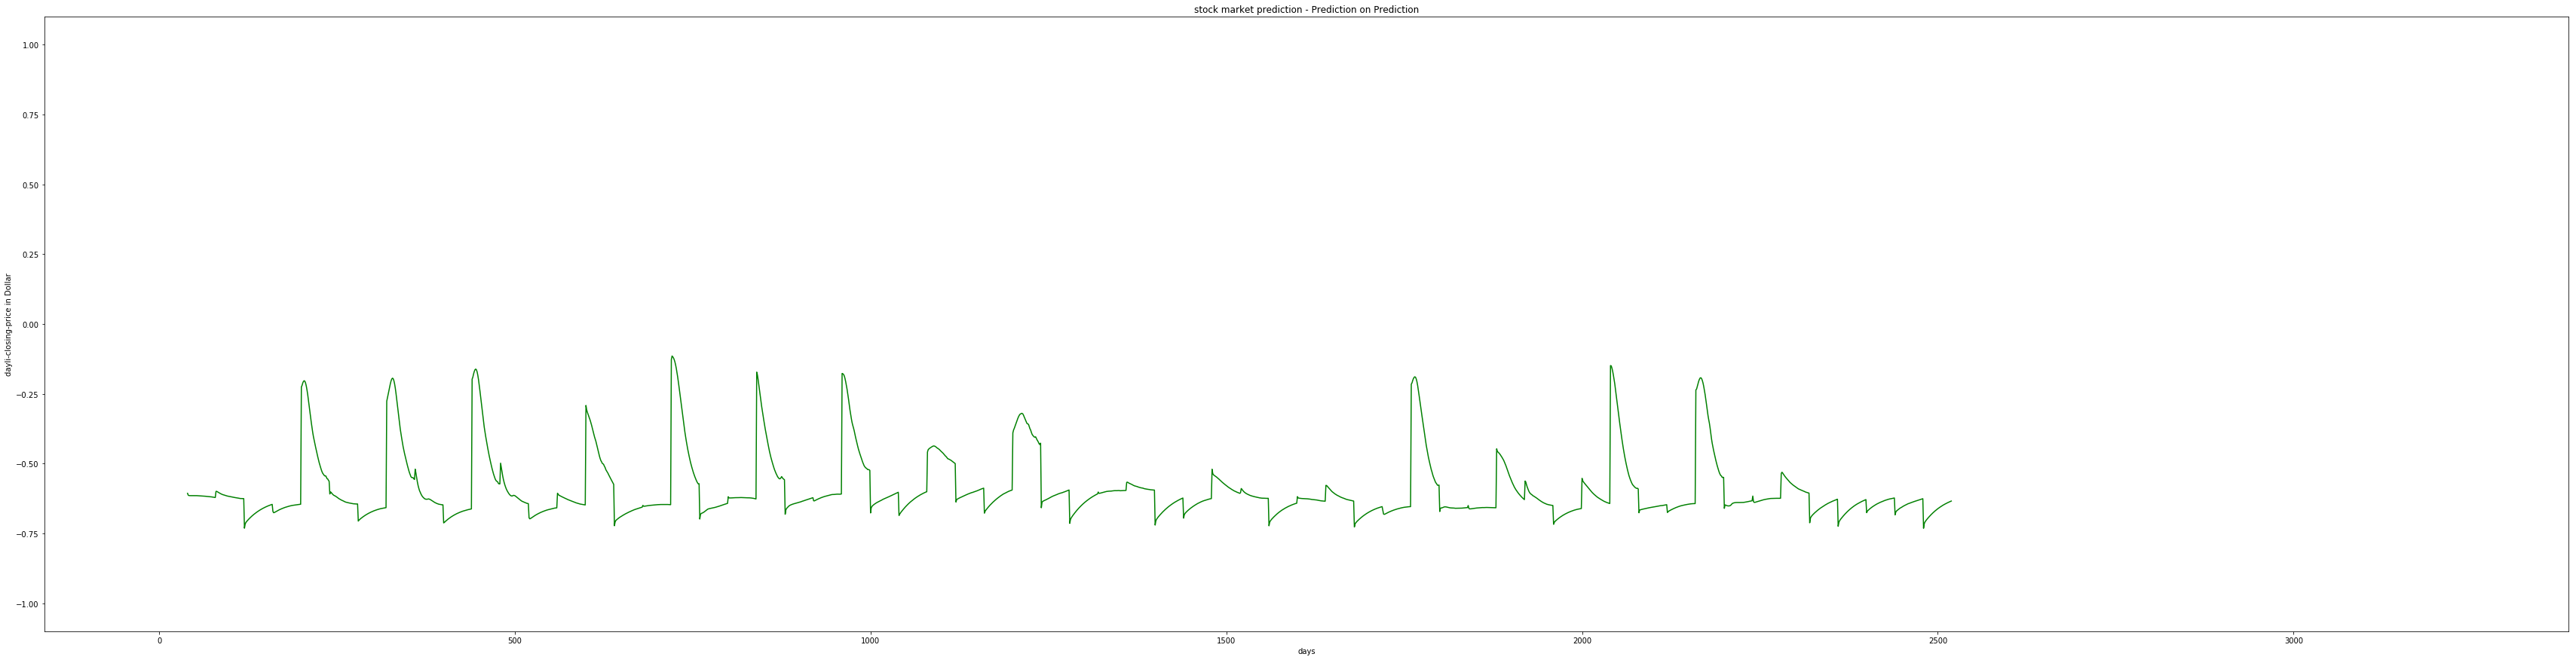


Number of existing points:  3226
Number of predicted points:  2480
Number of predicted points:  840




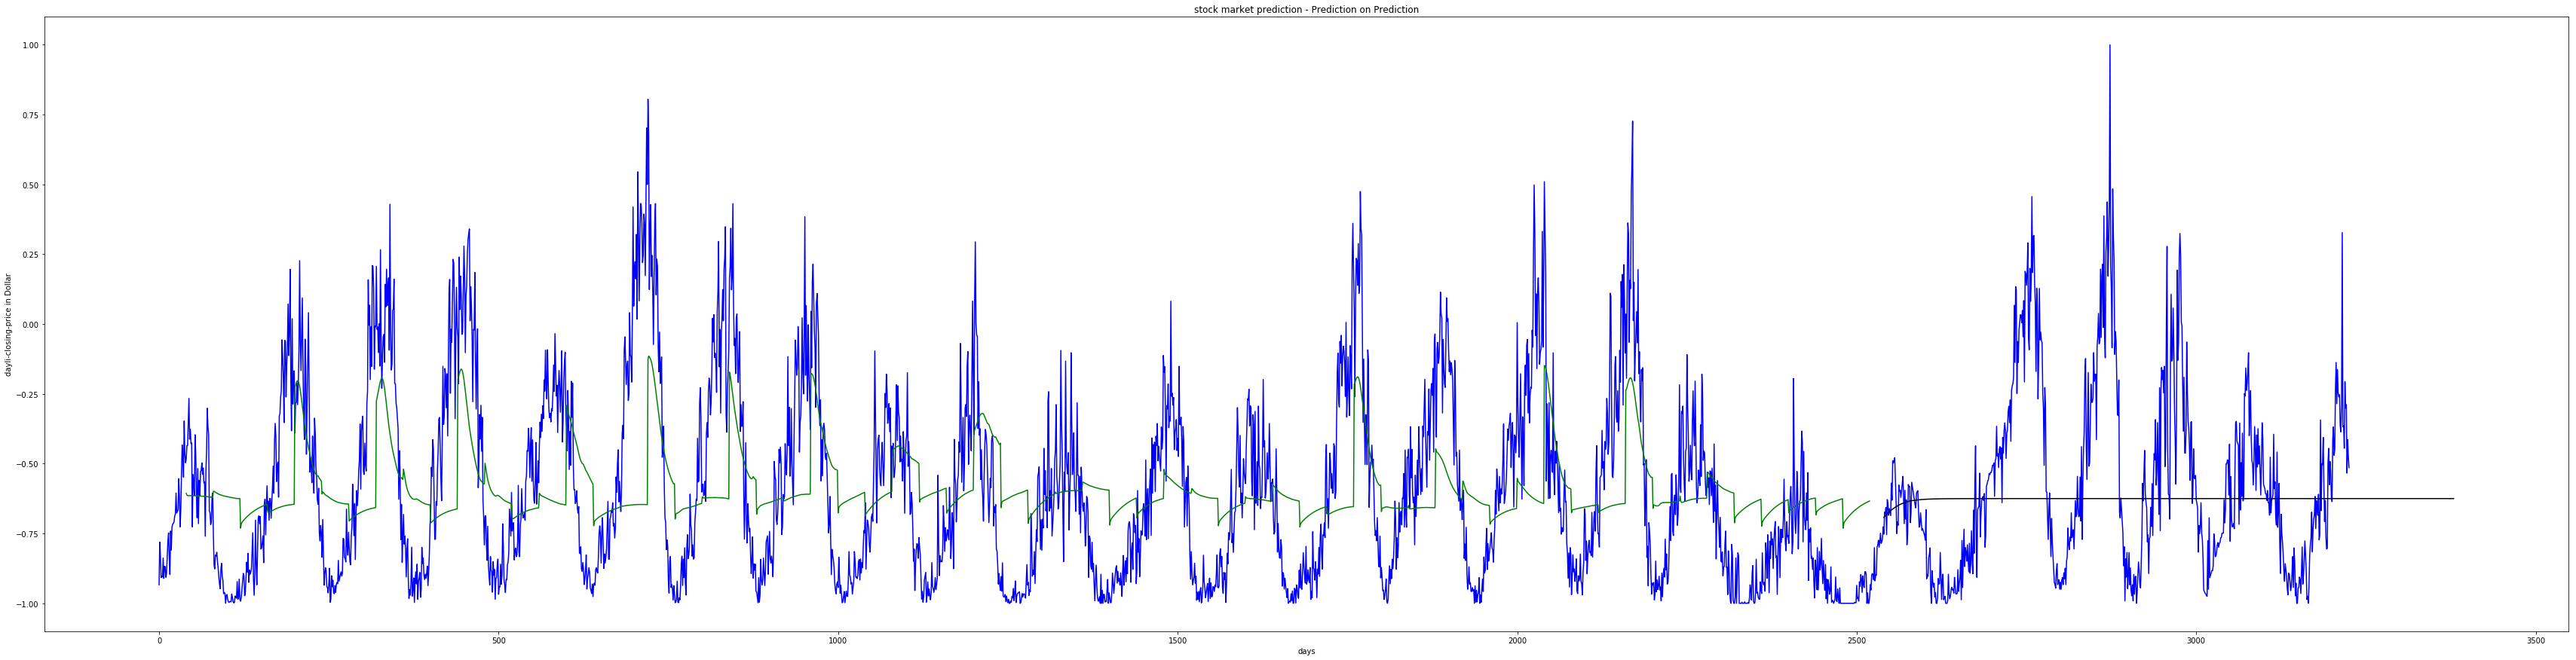

FINISHED


In [34]:
###################################################
print("START")
session = tf.Session()
session.run(tf.global_variables_initializer())
session.run(tf.local_variables_initializer())

run_all(session)
trainable_vars_dict = {}

session.close()
print("FINISHED")
###################################################

In [35]:
#run_tensorboard_in_jupiter(tf.get_default_graph().as_graph_def())

In [36]:
# run_tensorboard_in_browser(False)

In [37]:

# def condition(index_condition,up_to_condition,list_condition):
#     with tf.name_scope("model_loop_condition"):
#         return tf.less(index_condition,up_to_condition)

# def loop_dynamic_cell_body(index_body, up_to_body,list_body):
#     list[index_body] = index_body
#     index_body=index_body+1
#     return index_body, up_to_body,inputs_body,hidden_layer_size_body, number_of_classes_body,logits_list_body,in_list_body_out,weights_body, bias_body,summeries_in_while_body #im Moment können wir last_state noch weglassen, da wir mit ihm ehh nichts machen# run_tensorboard_in_browser(False)


# list = tf.Variable([],dtype=tf.string)
# test_data = tf.constant(["test","lol"])
# list_appendet = tf.concat([list,test_data],0)
# index=0
# up_to=4


# #while_result = tf.while_loop()

# session = tf.Session()
# session.run(tf.global_variables_initializer())
# session.run(tf.local_variables_initializer())

# result = session.run(list_appendet)
# print("result: ", result, " shape: ", result.shape)